In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('../')

In [1]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import argparse 

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Setup Datasets + Models

In [7]:
models_by_size = {}

for model_size in [2,5,10,15]:
    num_objects = 1
    noisy=False
    weight_decay = 0.0004
    encoder_model='mlp_{}_1'.format(model_size)
    optimizer = 'sgd'
    seed = 42

    models_by_size[model_size] = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy,encoder_model=encoder_model)
val_images, val_y, val_c = unroll_data(val_loader)

## Adversarial Results

In [10]:
activation_values = {}
ret_images = {}

for model_size in models_by_size:
    activation_values[model_size] = []
    ret_images[model_size] = []

    for concept_num in range(num_objects*2):
        ret_image = get_maximal_activation(models_by_size[model_size],run_joint_model,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32))
        activation_values[model_size].append (
            torch.nn.Sigmoid()(run_joint_model(models_by_size[model_size],ret_image)[1])[concept_num][0].detach().numpy()
        )

        ret_image = ret_image.detach()[0].numpy()
        ret_images[model_size].append(ret_image)


In [11]:
def random_right(img):
    img = deepcopy(img)
    img[0,:,128:] = ((torch.rand(1,256,128) < 0.5).long()-0.5)/2
    img[1,:,128:] = img[0,:,128:]
    img[2,:,128:] = 0.25

    return img

In [12]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

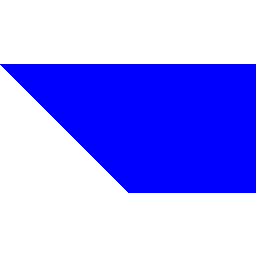

In [13]:
numpy_to_pil(val_images[0].detach().numpy())

In [14]:
dataset = torch.stack([random_right(val_images[0]) for i in range(20)])

In [15]:
for model_size in models_by_size:
    y,c = run_joint_model(models_by_size[model_size],dataset)
    print(torch.argmax(c.T,dim=1))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


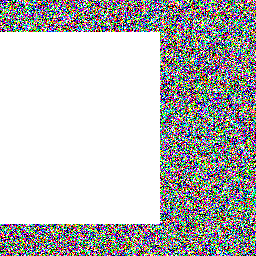

In [16]:
numpy_to_pil(ret_images[2][0])

## Analyzing Weights

In [217]:
model_size = 2

In [218]:
clean_image_0 = val_images[torch.where(val_c == torch.Tensor([1,0]))[0][0]]
clean_image_1 = val_images[torch.where(val_c == torch.Tensor([0,1]))[0][0]]


In [219]:
adversarial_image_0 = torch.Tensor(ret_images[model_size][0])
adversarial_image_1 = torch.Tensor(ret_images[model_size][1])

In [220]:
all_inputs = torch.stack([clean_image_0,adversarial_image_0,clean_image_1,adversarial_image_1])

In [221]:
torch.argmax(run_joint_model(models_by_size[model_size],all_inputs)[1].T,dim=1)

tensor([1, 1, 1, 1])

In [222]:
all_inputs.shape

torch.Size([4, 3, 256, 256])

In [223]:
first_results = models_by_size[model_size].first_model.linear(all_inputs.reshape(4,3*256*256))

In [224]:
np.set_printoptions(suppress=True)
np.round(first_results.detach().numpy(),2)

array([[-51.29,  -0.13],
       [-14.3 ,  -0.31],
       [-41.7 ,  -0.05],
       [-14.03,  -7.07]], dtype=float32)

In [225]:
activated_first_results = models_by_size[model_size].first_model.activation(first_results)

In [226]:
linear_2_weights = models_by_size[model_size].first_model.linear2.weight
linear_2_weights.shape

torch.Size([2, 2])

In [227]:
product_0 = linear_2_weights[0]*activated_first_results
product_1 = linear_2_weights[1]*activated_first_results 

In [228]:
product_0[0]

tensor([-0., 0.], grad_fn=<SelectBackward0>)

In [229]:
product_0[1]

tensor([-0., 0.], grad_fn=<SelectBackward0>)

In [230]:
product_1[2]

tensor([0., -0.], grad_fn=<SelectBackward0>)

In [231]:
product_1[3]

tensor([0., -0.], grad_fn=<SelectBackward0>)

In [232]:
adversarial_0_max = torch.argmax(product_0[1])
adversarial_1_max = torch.argmax(product_1[3])
adversarial_0_max, adversarial_1_max

(tensor(0), tensor(0))

In [233]:
torch.sum(product_0,dim=1), torch.sum(product_1,dim=1)

(tensor([0., 0., 0., 0.], grad_fn=<SumBackward1>),
 tensor([0., 0., 0., 0.], grad_fn=<SumBackward1>))

## Maximizers by Weight

In [234]:
linear_1_weights = models_by_size[model_size].first_model.linear.weight.reshape((model_size,3,256,256))
linear_1_weights = ((linear_1_weights>0).long()-0.5)/2
linear_1_weights.shape

torch.Size([2, 3, 256, 256])

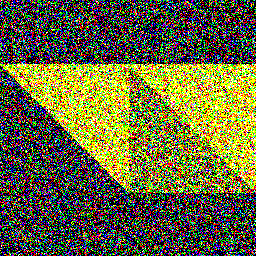

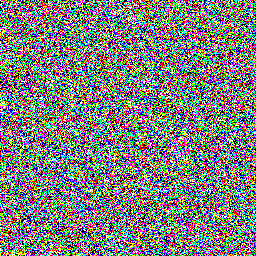

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [235]:
for i in range(model_size):
    pil_image = numpy_to_pil(linear_1_weights[i].detach().numpy())
    display(pil_image)
    plt.figure()


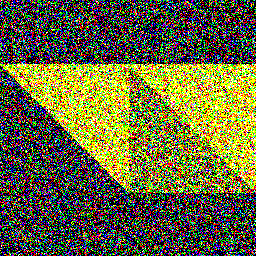

In [236]:
pil_image = numpy_to_pil(linear_1_weights[adversarial_0_max].detach().numpy())
display(pil_image)

In [237]:
run_joint_model(models_by_size[model_size],torch.stack([linear_1_weights[adversarial_0_max]]))

(tensor([[-0.9527, -0.4054]], grad_fn=<AddmmBackward0>),
 tensor([[-15.5415],
         [  6.6193]], grad_fn=<SqueezeBackward1>))

In [238]:
modified_image = deepcopy(linear_1_weights[torch.argmax(product_0[0])])
modified_image[:,:,:128] = torch.Tensor([0.25,0.25,0.25]).repeat((256,128)).reshape((3,256,128))
run_joint_model(models_by_size[model_size],torch.stack([modified_image]))

(tensor([[-0.8341, -0.4109]], grad_fn=<AddmmBackward0>),
 tensor([[-3.3780],
         [ 1.4796]], grad_fn=<SqueezeBackward1>))

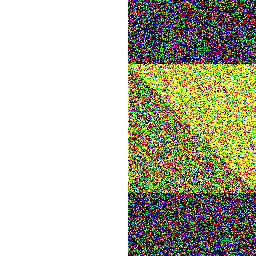

In [239]:
numpy_to_pil(modified_image.detach().numpy())

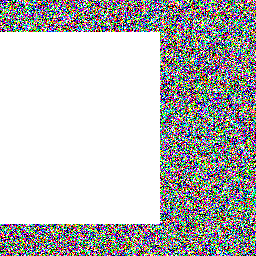

In [240]:
numpy_to_pil(ret_images[model_size][0])

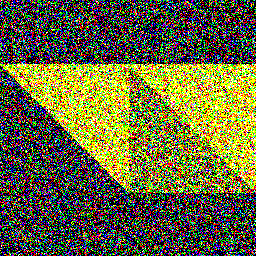

In [241]:
pil_image = numpy_to_pil(linear_1_weights[adversarial_1_max].detach().numpy())
display(pil_image)

In [242]:
run_joint_model(models_by_size[model_size],torch.stack([linear_1_weights[adversarial_1_max]]))

(tensor([[-0.9527, -0.4054]], grad_fn=<AddmmBackward0>),
 tensor([[-15.5415],
         [  6.6193]], grad_fn=<SqueezeBackward1>))

In [243]:
modified_image = deepcopy(linear_1_weights[torch.argmax(product_1[2])])
modified_image[:,:,:128] = torch.Tensor([0.25,0.25,0.25]).repeat((256,128)).reshape((3,256,128))
run_joint_model(models_by_size[model_size],torch.stack([modified_image]))

(tensor([[-0.8341, -0.4109]], grad_fn=<AddmmBackward0>),
 tensor([[-3.3780],
         [ 1.4796]], grad_fn=<SqueezeBackward1>))

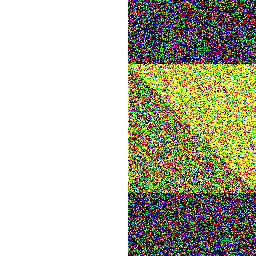

In [244]:
numpy_to_pil(modified_image.detach().numpy())

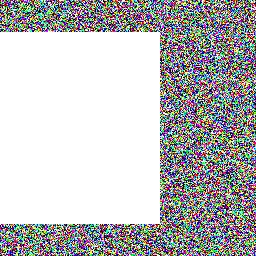

In [245]:
numpy_to_pil(ret_images[model_size][1])